# Evaluation of the GAN Greyscale 64 px model

# 1. Import Libaries

In [1]:
import os
import shutil
import sys
import numpy as np
sys.path.append('../src/models/')
sys.path.append('../src/utils/')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as dset
from torchvision import transforms
from torch import autograd
import torch.optim as optim
import torchvision.utils as vutils # draw bounding box, segmantation mask, keypoints. convert to rgb, make grid, save_image

import matplotlib.pyplot as plt

from GNet64_Greyscale import OptGenGreyscale
from DNet64 import OptDis

from utils import weights_init

import ignite
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore, RunningAverage
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine, Events
from ignite.handlers import *
import PIL.Image as Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

# 2. Set Parameters

In [2]:
cadastralRootGreyscale = '../../cadastralExport'
image_size = 64
batch_size = 20
workers = 4
noise_size = 8
noise_channels = 2
nz = noise_channels*noise_size*noise_size # Size of z latent vector (i.e. size of generator input)
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.9 # Beta1 hyperparam for Adam optimizers
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# device = 'cpu'
recording_step = 1 # how often to record the information during the training

# 3. Import Real Images

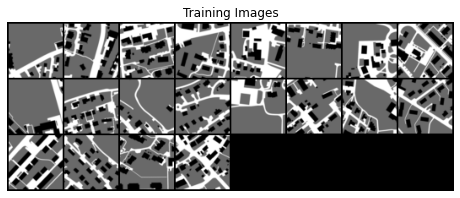

In [3]:
# We can use an image folder dataset the way we have it setup
if os.path.exists(cadastralRootGreyscale + '/.ipynb_checkpoints'):
    shutil.rmtree(cadastralRootGreyscale + '/.ipynb_checkpoints')

Cad_dataset_greyscale = dset.ImageFolder(root=cadastralRootGreyscale,
                           transform=transforms.Compose([
                               transforms.RandomRotation(degrees=(0,180), expand = False),
                               transforms.CenterCrop(image_size * 8),
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transforms.Grayscale(num_output_channels=1)
                           ]))
# Create the dataloader
Cad_dataloader_greyscale = torch.utils.data.DataLoader(Cad_dataset_greyscale, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Load some training images
xr = next(iter(Cad_dataloader_greyscale))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(xr[0].to(device)[:20], 
                                         padding=2, normalize=True).cpu(),(1,2,0)));

In [4]:
Cad_dataset_greyscale

Dataset ImageFolder
    Number of datapoints: 2569
    Root location: ../../cadastralExport
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[0.0, 180.0], interpolation=nearest, expand=False, fill=0)
               CenterCrop(size=(512, 512))
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Grayscale(num_output_channels=1)
           )

# 4. Import Model

In [7]:
netG256 = torch.load('../models/Greyscale256_NetG_Training').to(device)
netD256 = torch.load('../models/Greyscale256_NetD_Training').to(device)

In [9]:
z = torch.randn(batch_size, nz, 1, 1, device=device)
xf = netG256.forward(z)
xn = xf + 1e+0 * torch.randn(*xf.size(), device=device)

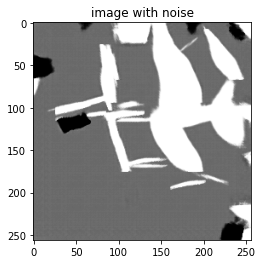

In [10]:
plt.title('image with noise')
plt.imshow(xf[0].detach().cpu().permute(1,2,0), cmap='gray');

In [11]:
xn[0][0]

tensor([[-0.8091, -0.2447,  0.8184,  ..., -0.5173,  0.2776,  1.3812],
        [ 0.3588, -0.1304, -1.9067,  ...,  1.4850, -0.7969,  0.1366],
        [-0.4009,  0.5811, -1.2457,  ...,  2.7753,  0.7590,  0.8358],
        ...,
        [-0.2614,  1.1444,  0.8097,  ...,  1.7735,  1.8997,  0.4582],
        [ 0.7610, -0.5508, -1.5906,  ...,  2.0951,  1.7717,  0.2733],
        [-1.1797, -2.0510,  0.9590,  ...,  1.9061,  0.7035,  0.0289]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [12]:
if torch.linalg.matrix_rank(xn[0][0]) ==  256:
    print('Ok')

Ok


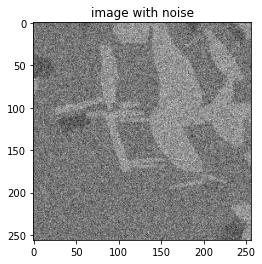

In [13]:
plt.title('image with noise')
plt.imshow(xn[0].detach().cpu().permute(1,2,0), cmap='gray');

## 4.1 New 64px grey scale Gnet

In [14]:
netG64 = OptGenGreyscale(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.3).to(device)
netG64.apply(weights_init)
print(netG64)

OptGenGreyscale(
  (main): Sequential(
    (0): ConvTranspose2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): TransConv_2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.3, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU_2): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): TransConv_3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (8): DropOut_3): Dropout2d(p=0.3, inplace=False)
    (9): BatchNorm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU_3): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): TransConv_4): ConvTranspose2d(64, 1, kern

In [15]:
netD64 = OptDis(ngpu=ngpu, num_conv_layers=3, in_channels=1).to(device)
netD64.apply(weights_init)
print(netG64)

OptGenGreyscale(
  (main): Sequential(
    (0): ConvTranspose2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): TransConv_2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.3, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU_2): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): TransConv_3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (8): DropOut_3): Dropout2d(p=0.3, inplace=False)
    (9): BatchNorm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU_3): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): TransConv_4): ConvTranspose2d(64, 1, kern

# 5. Calculating FID

## 5.1 Define training steps
even if no training is needed this notebooks follows the example from ignite https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/ step by step

In [16]:
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=idist.device())

In [17]:
optimizerD = idist.auto_optim(optim.Adam(netD64.parameters(), lr=0.0002, betas=(0.9, 0.999)))
optimizerG = idist.auto_optim(optim.Adam(netG64.parameters(), lr=0.0002, betas=(0.9, 0.999)))

In [18]:
def training_step(engine, data):
    # Set the models for training
    netG64.train()
    netD64.train()
    # (1) Update D network
    netD64.zero_grad()
    ## Train with all-real batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    predr = netD64(real).view(-1)
    errD_real = -(predr.mean())
    errD_real.backward()
    ## Train with all-fake batch
    z = torch.randn(b_size, nz, 1, 1, device=idist.device())
    fake = netG64(z)
    predf1 = netD64(fake.detach()).view(-1)
    errD_fake = predf1.mean()
    errD_fake.backward()
    errD = errD_real + errD_fake
    optimizerD.step()
    
    # (2) Update G network
    netG64.zero_grad()
    predf2 = netD64(fake).view(-1)
    errG = -predf2.mean()
    errG.backward()
    optimizerG.step()
    
    return({"Loss_G" : errG.item(),
            "Loss_D" : errD.item(),
            "D_x": predr.mean().item(),
            "D_G_z1": predf1.mean().item(),
            "D_G_z2": predf2.mean().item()})

In [19]:
trainer = Engine(training_step)

## 5.2 Recording performances

In [20]:
G_losses = []
D_losses = []


@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])

In [21]:
img_list = []


@trainer.on(Events.ITERATION_COMPLETED(every=recording_step))
def store_images(engine):
    with torch.no_grad():
        fake = netG64(fixed_noise).cpu()
    img_list.append(fake)

## 5.3 Calculate metrics

In [22]:
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

In [23]:
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299, 299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

In [24]:
def evaluation_step(engine, batch):
    # pic_counter = 0
    with torch.no_grad():
        # pic_counter += batch[0].size(0)
        noise = torch.randn(batch[0].size(0), nz, 1, 1, device=device)
        netG64.eval()
        # import code 
        # code.interact(local=dict(globals(), **locals()))
        fake_batch = netG64.forward(noise)
        # fake_batch = fake_batch + 1e-6 * torch.randn(*fake_batch.size(), device=device)
        # for i in range(len(fake_batch)):
        #     rank = torch.linalg.matrix_rank(fake_batch[i][0])
        #     if rank != image_size:
        #         print(f'Found image with not full rank of: {rank}')
        fake_batch = fake_batch.repeat(1, 3, 1, 1)
        # print(f'fake batch size: {fake_batch.size()}')
        # print(f'real batch size: {batch[0].size()}')
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        # print(f'fake batch size after interpolation: {fake.size()}')
        # print(f'real batch size after interpolation: {real.size()}')
        # print(f'total number of pics seen: {pic_counter}')
        return fake, real

In [25]:
evaluator = Engine(evaluation_step)
is_metric.attach(evaluator, "is")

In [26]:
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(Cad_dataloader_greyscale, max_epochs=1)
    metrics = evaluator.state.metrics
    is_score = metrics['is']
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*    IS : {is_score:4f}")

## 5.4 Loss Metrics

In [27]:
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

## 5.5 Progress Bars

In [28]:
ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)

/opt/anaconda3/lib/python3.9/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# 6. Training

In [43]:
def training(*args):
    trainer.run(Cad_dataloader_greyscale, max_epochs=30)

In [44]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

2023-06-30 18:54:57,210 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2023-06-30 18:54:57,211 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7f7a6b02eb80>' in 1 processes


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [11/5] Metric Scores
*    IS : 1.862298


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [12/5] Metric Scores
*    IS : 1.595587


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [13/5] Metric Scores
*    IS : 1.361112


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [14/5] Metric Scores
*    IS : 1.499095


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [15/5] Metric Scores
*    IS : 1.814178


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [16/5] Metric Scores
*    IS : 1.516619


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [17/5] Metric Scores
*    IS : 1.448878


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [18/5] Metric Scores
*    IS : 1.450172


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [19/5] Metric Scores
*    IS : 1.427283


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [20/5] Metric Scores
*    IS : 1.727677


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [21/5] Metric Scores
*    IS : 1.543926


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [22/5] Metric Scores
*    IS : 1.423548


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [23/5] Metric Scores
*    IS : 1.362095


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [24/5] Metric Scores
*    IS : 1.514579


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [25/5] Metric Scores
*    IS : 1.516735


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [26/5] Metric Scores
*    IS : 1.435946


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [27/5] Metric Scores
*    IS : 1.353467


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [28/5] Metric Scores
*    IS : 1.387437


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [29/5] Metric Scores
*    IS : 1.497849


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

2023-06-30 19:56:41,534 ignite.distributed.launcher.Parallel INFO: End of run
2023-06-30 19:56:41,535 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


Epoch [30/5] Metric Scores
*    IS : 1.421829


# 7 Inference

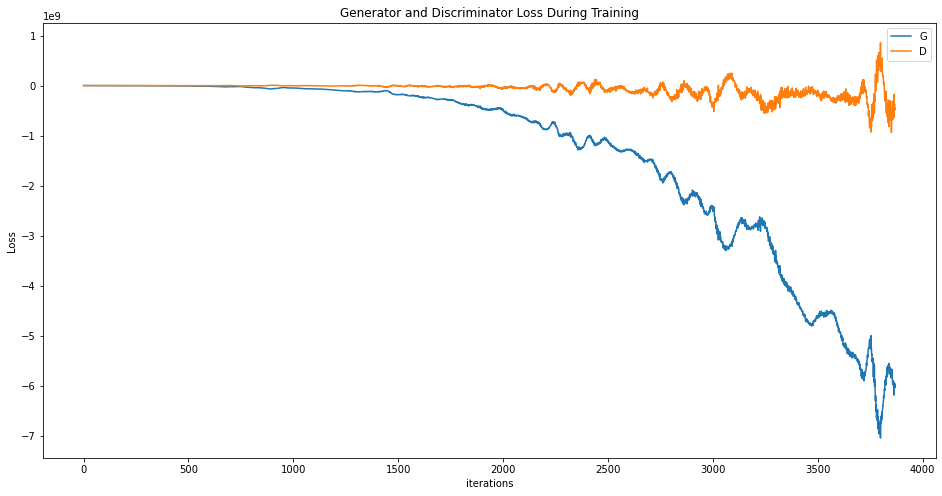

In [45]:
plt.figure(figsize=(16,8))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend();

# 7.1 Evaluation Metrics vs Training iterations

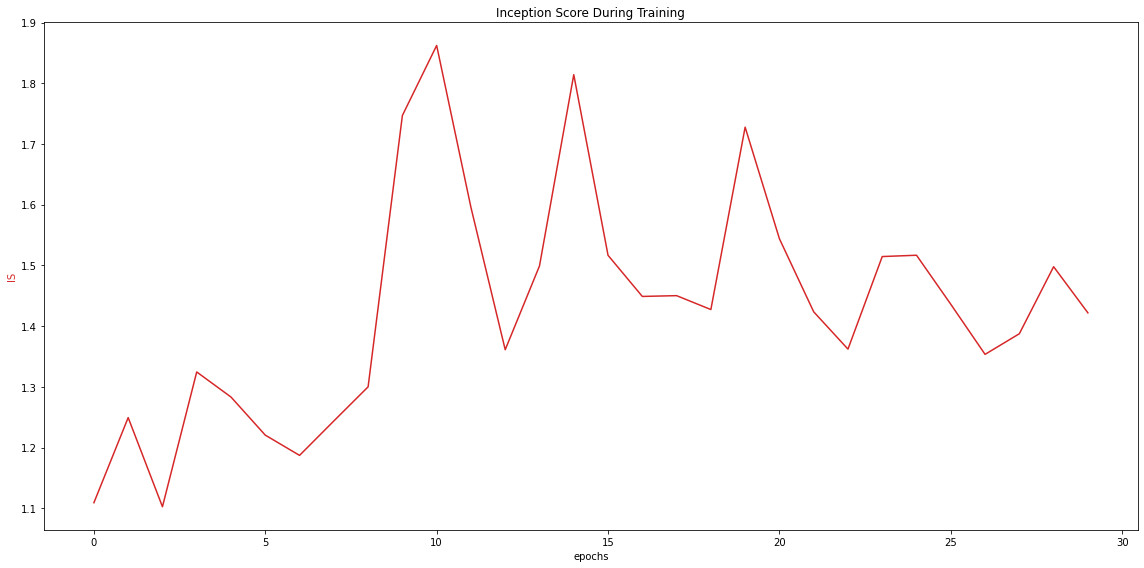

In [46]:
fig, ax1 = plt.subplots(figsize=(16,8))

plt.title("Inception Score During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)
# 
# ax2 = ax1.twinx()
# 
# color = 'tab:blue'
# ax2.set_ylabel('FID', color=color)
# ax2.plot(fid_values, color=color)

fig.tight_layout()

In [47]:
np.mean(is_values) 

1.4308942215996197

In [48]:
np.min(is_values)

1.1024521003256669

In [49]:
np.max(is_values)

1.8622983656177559

In [50]:
q75, q25 = np.percentile(is_values, [75 ,25])
iqr = q75 - q25
iqr

0.21000553556340518

# 8 Training with Gradient Clamp

In [55]:
def training_clamp_step(engine, data):
    # Set the models for training
    netG64.train()
    netD64.train()
    # (1) Update D network
    netD64.zero_grad()
    ## Train with all-real batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    predr = netD64(real).view(-1)
    errD_real = -(predr.mean())
    errD_real.backward()
    ## Train with all-fake batch
    z = torch.randn(b_size, nz, 1, 1, device=idist.device())
    fake = netG64(z)
    predf1 = netD64(fake.detach()).view(-1)
    errD_fake = predf1.mean()
    errD_fake.backward()
    errD = errD_real + errD_fake
    optimizerD.step()
    for p in netD64.parameters():
        p.data.clamp_(-0.01, 0.01)
    
    # (2) Update G network
    netG64.zero_grad()
    predf2 = netD64(fake).view(-1)
    errG = -predf2.mean()
    errG.backward()
    optimizerG.step()
    
    return({"Loss_G" : errG.item(),
            "Loss_D" : errD.item(),
            "D_x": predr.mean().item(),
            "D_G_z1": predf1.mean().item(),
            "D_G_z2": predf2.mean().item()})

In [81]:
netG64 = OptGenGreyscale(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.3).to(device)
netG64.apply(weights_init)

netD64 = OptDis(ngpu=ngpu, num_conv_layers=3, in_channels=1).to(device)
netD64.apply(weights_init)

optimizerD = idist.auto_optim(optim.Adam(netD64.parameters(), lr=0.0002, betas=(0.9, 0.999)))
optimizerG = idist.auto_optim(optim.Adam(netG64.parameters(), lr=0.0002, betas=(0.9, 0.999)))

G_losses = []
D_losses = []

img_list = []

is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

evaluator = Engine(evaluation_step)
is_metric.attach(evaluator, "is")

is_values = []

trainer = Engine(training_clamp_step)

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(Cad_dataloader_greyscale, max_epochs=1)
    metrics = evaluator.state.metrics
    is_score = metrics['is']
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*    IS : {is_score:4f}")

@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])
    
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)

In [82]:
def training(*args):
    trainer.run(Cad_dataloader_greyscale, max_epochs=30)

In [83]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

2023-06-30 22:02:22,894 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2023-06-30 22:02:22,896 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7f7a06ddf700>' in 1 processes


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [1/5] Metric Scores
*    IS : 1.080857


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [2/5] Metric Scores
*    IS : 1.085024


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [3/5] Metric Scores
*    IS : 1.094212


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [4/5] Metric Scores
*    IS : 1.101529


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [5/5] Metric Scores
*    IS : 1.094398


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [6/5] Metric Scores
*    IS : 1.086955


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [7/5] Metric Scores
*    IS : 1.084290


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [8/5] Metric Scores
*    IS : 1.071137


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [9/5] Metric Scores
*    IS : 1.076217


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [10/5] Metric Scores
*    IS : 1.091007


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [11/5] Metric Scores
*    IS : 1.149116


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [12/5] Metric Scores
*    IS : 1.446329


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [13/5] Metric Scores
*    IS : 1.694563


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [14/5] Metric Scores
*    IS : 1.205947


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [15/5] Metric Scores
*    IS : 1.262119


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [16/5] Metric Scores
*    IS : 1.216893


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [17/5] Metric Scores
*    IS : 1.229581


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [18/5] Metric Scores
*    IS : 1.289070


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [19/5] Metric Scores
*    IS : 1.299806


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [20/5] Metric Scores
*    IS : 1.309888


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [21/5] Metric Scores
*    IS : 1.245897


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [22/5] Metric Scores
*    IS : 1.293210


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [23/5] Metric Scores
*    IS : 1.342205


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [24/5] Metric Scores
*    IS : 1.286608


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [25/5] Metric Scores
*    IS : 1.341000


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [26/5] Metric Scores
*    IS : 1.341960


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [27/5] Metric Scores
*    IS : 1.386642


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [28/5] Metric Scores
*    IS : 1.340066


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

Epoch [29/5] Metric Scores
*    IS : 1.360835


[1/129]   1%|           [00:00<?]

[1/129]   1%|           [00:00<?]

2023-06-30 22:47:34,024 ignite.distributed.launcher.Parallel INFO: End of run
2023-06-30 22:47:34,026 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


Epoch [30/5] Metric Scores
*    IS : 1.397055


In [84]:
is_values

[1.0808565584268524,
 1.0850242923461966,
 1.094211985090355,
 1.1015289896566265,
 1.0943975084918165,
 1.0869552632179258,
 1.084290281013292,
 1.071136854215339,
 1.076217404902179,
 1.0910068435437976,
 1.149115698875254,
 1.4463288210422827,
 1.6945631789448878,
 1.2059468667834563,
 1.2621193710604457,
 1.2168933788010512,
 1.2295813697015792,
 1.289070197395952,
 1.2998057789606638,
 1.309888160707636,
 1.2458967175491524,
 1.2932098309852238,
 1.3422046059807977,
 1.2866079790434262,
 1.3409999587860892,
 1.3419599830086597,
 1.386642156256025,
 1.3400663630080178,
 1.3608354129124844,
 1.3970548639986533]

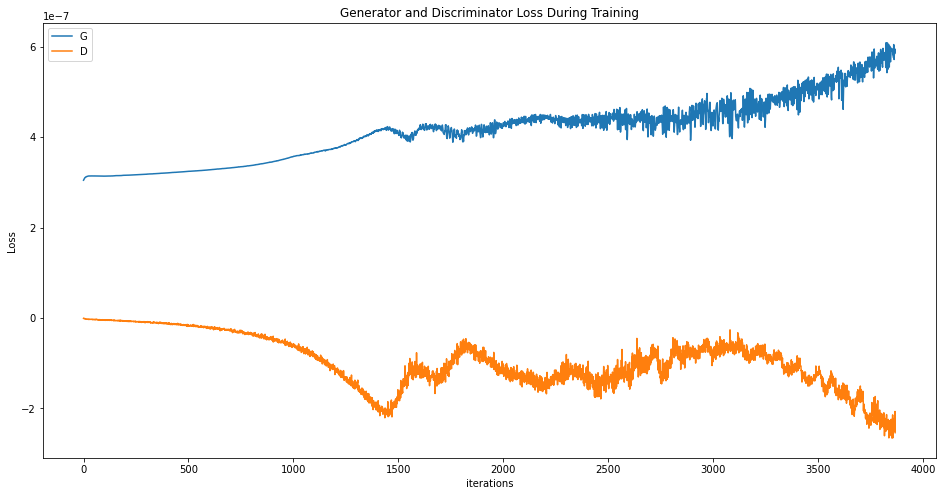

In [86]:
plt.figure(figsize=(16,8))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[1:],label="G")
plt.plot(D_losses[1:],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend();

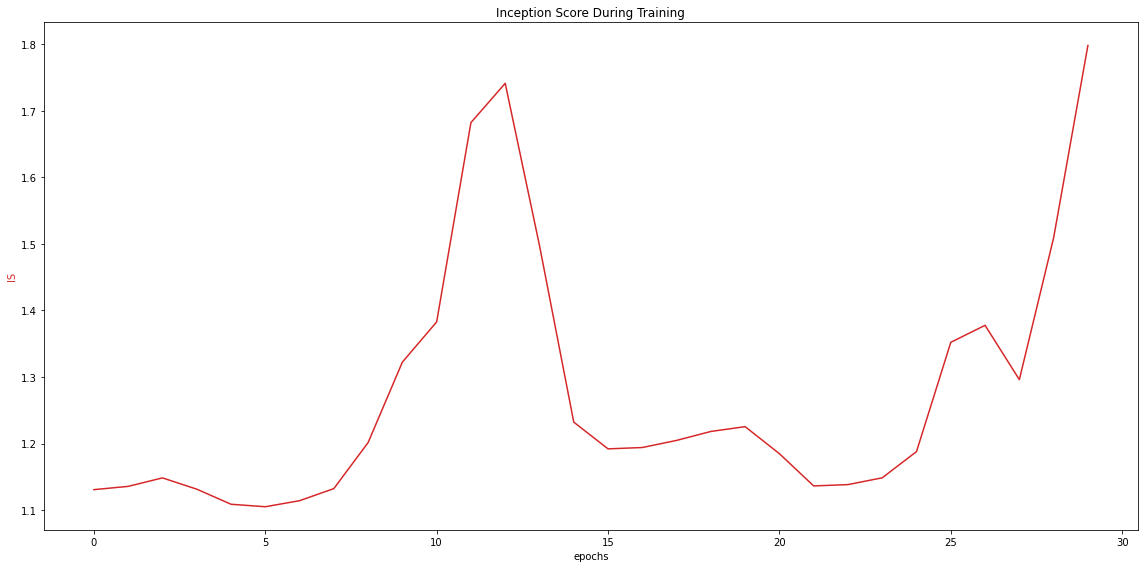

In [78]:
fig, ax1 = plt.subplots(figsize=(16,8))

plt.title("Inception Score During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

fig.tight_layout()

In [79]:
q75, q25 = np.percentile(is_values, [75 ,25])
iqr = q75 - q25
iqr
print(f'IC Mean: {np.round(np.mean(is_values), 4)}')
print(f'IC Min:  {np.round(np.min(is_values), 4)}')
print(f'IC Max:  {np.round(np.max(is_values), 4)}')
print(f'IC IQR:  {np.round(iqr, 4)}')

IC Mean: 1.2744
IC Min:  1.1052
IC Max:  1.798
IC IQR:  0.2078


# Archive

### Inception Score
2.981063175725717

In [91]:
evaluatorFID = Engine(evaluation_step)
fid_metric.attach(evaluatorFID, "fid")
fid_values = []

evaluatorFID.run(Cad_dataloader_greyscale, max_epochs=2)
metrics = evaluatorFID.state.metrics
fid_score = metrics['fid']
fid_values.append(fid_score)

Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full

Engine run is terminating due to exception: Imaginary component 1.396992337264449e+216


ValueError: Imaginary component 1.396992337264449e+216

### Manual Inception Score

In [63]:
import numpy as np
from scipy import linalg
import warnings

def fid(mn1, cov1, mn2, cov2, eps=1e-6):
    mn1 = np.atleast_1d(mn1)
    mn2 = np.atleast_1d(mn2)
    
    cov1 = np.atleast_2d(cov1)
    cov2 = np.atleast_2d(cov2)
    
    diff = mn1 - mn2
        
    # product might be almost singular
    covmean, _ = linalg.sqrtm(cov1.dot(cov2), disp=False)
    if not np.isfinite(covmean).all():
        warnings.warn(("fid() got singular product; adding {} to diagonal of "
                       "cov estimates").format(eps))
        offset = np.eye(d) * eps
        covmean = linalg.sqrtm((cov1 + offset).dot(cov2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(cov1) + np.trace(cov2) - 2 * tr_covmean

In [66]:
sample = next(iter(Cad_dataloader_greyscale))[0]
sample.size()

torch.Size([64, 3, 256, 256])

In [73]:
sampleUS = interpolate(sample)

In [75]:
fid_metric

### Frechet Inception Distance


In [28]:
noise = torch.randn(64, nz, 1, 1, device=idist.device())
fake_batch = NetG64(noise)

In [29]:
fake_batch.size()

torch.Size([64, 1, 256, 256])

In [30]:
fake_batch_rgb=fake_batch.repeat(1,3,1,1)

In [31]:
fake_batch_rgb.size()

torch.Size([64, 3, 256, 256])

In [24]:
noisergb=noise.repeat(1,3,1,1)

In [25]:
noisergb.size()

torch.Size([64, 768, 1, 1])

In [27]:
noise.size()

torch.Size([64, 256, 1, 1])

In [ ]:
### arr = []
### for i in range(xr[0].size(0)):
###     pil_img = transforms.ToPILImage()(xr[0][i])
###     resized_img = pil_img.resize((299,299), Image.BILINEAR)
###     arr.append(transforms.ToTensor()(resized_img))
### arr[i].size()

In [ ]:
### xr_int = torch.stack(arr)
### print(f'real batch size after interpolation: {xr_int.size()}')

the training function is loaded from src/utils/OptimisationFunctions

In [172]:
from OptimisationFunctions import trainModel

In [187]:
### # Params for the trainModel function
### # device: torch.device, dataloader: torch.utils.data.dataloader.DataLoader, 
### #                optimizerG, optimizerD, 
### #                fixed_noise:torch.Tensor, folder: str, epochs: int = 10, nz: int = 100,
### #                experiment: str = 'WGANRGB',
### #                AlternativeTraining: int = 0, logger: logging.Logger = None
### optimizerG = optim.Adam(NetG64.parameters(), lr=lr, betas=(beta1, 0.999))
### optimizerD = optim.Adam(NetD64.parameters(), lr=lr, betas=(beta1, 0.999))

SyntaxError: invalid syntax (2315953629.py, line 9)

In [188]:
### trainer = Engine(trainModel(netG=NetG64, netD=NetD64, device=device, dataloader=Cad_dataloader_greyscale, 
###         optimizerG=optimizerG, optimizerD=optimizerD, fixed_noise=z, folder='../', epochs = 2, nz=nz, 
###        experiment = 'evalution_test'))

Epoch: 0/2 | D Learn: True | D Loss: 22059.916| ErrDReal: -9073.0088 | ErrDFake: 31132.8203 | GradPenality: 0.1043 | G Loss: -25721.2949


TypeError: [tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3899,  ..., 0.3134, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.3252,  ..., 0.1913, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2981,  ..., 0.3369, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.3178,  ..., 0.3536, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3294,  ..., 0.3708, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.3038,  ..., 0.3651, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])] is not a callable object

torch.Size([3, 299, 299])

In [135]:
xr_int = torch.stack(arr)
print(f'real batch size after interpolation: {xr_int.size()}')

real batch size after interpolation: torch.Size([64, 3, 299, 299])


In [132]:
print(f'xr size = {xr[0].size()}') 
interpolated = interpolate(xr[0])
print(f'xr interpolated size = {interpolated.size()}') 

xr size = torch.Size([64, 3, 256, 256])
xr interpolated size = torch.Size([64, 3, 256, 256])


In [ ]:
metrics

In [87]:
fid_values = []
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

NameError: name 'trainer' is not defined

In [86]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=5)

In [62]:
fid_metric.attach(evaluator, "fid")

In [64]:
with torch.no_grad():
    state = evaluator.run([[xf, xr]])

In [65]:
state

In [57]:
def eval_step(engine, batch):
    return batch

In [58]:
default_evaluator = Engine(eval_step)

In [59]:
metric = FID(device=device)
metric.attach(default_evaluator, "fid")

In [60]:
y_true = torch.ones(10, 4)
y_pred = torch.ones(10, 4)
state = default_evaluator.run([[y_pred, y_true]])
print(state.metrics["fid"])

Current run is terminating due to exception: Inputs should be a tensor of dim 4, got 2
Engine run is terminating due to exception: Inputs should be a tensor of dim 4, got 2


ValueError: Inputs should be a tensor of dim 4, got 2

In [ ]:
def evaluation_step(engine, data):
    return

In [ ]:
evaluator = Engine(evaluation_step)

In [67]:
fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

In [47]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

NameError: name 'models' is not defined

In [33]:
def calculate_activation_statistics(images,model,batch_size=64, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [34]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [35]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1, std_1 = calculate_activation_statistics(images_real,model,cuda=True)
     mu_2, std_2 = calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

In [ ]:
calculate_fretchet(images_real=xr, images_fake=xf, model=)

In [44]:
FID.eval()

AttributeError: type object 'FID' has no attribute 'eval'